# emulate dust attenuation in TNG

In [15]:
import h5py
import numpy as np 
from tqdm.auto import trange

In [2]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read `subfind` catalog for unattenuated magnitudes

In [3]:
nsubhalos = 0
mstars, mags_unatten = [], []
for i in range(600): 
    ftng = h5py.File('/tigress/chhahn/goleta/tng/fof_subhalo_tab_099.%i.hdf5' % i, 'r')
    try: 
        mstars.append(ftng['Subhalo/SubhaloMassType'][...][:,4])
        _mags = ftng['Subhalo/SubhaloStellarPhotometrics'][...][:,-4:] # g, r, i, z band magnitudes
        mags_unatten.append(_mags)
        
        nsubhalos += _mags.shape[0]
    except KeyError: 
        continue
        
mstars = np.concatenate(mstars)
mags_unatten = np.concatenate(mags_unatten, axis=0)

## read SDSS g, r, i, z photometry with dust

In [4]:
f = h5py.File('/tigress/chhahn/goleta/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5', 'r')
mags_atten = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,1:5,0] # g, r, i, z

In [5]:
assert mags_unatten.shape[0] == mags_atten.shape[0]

In [6]:
mlim = (mstars > 0)

mags_unatten = mags_unatten[mlim]
mags_atten = mags_atten[mlim]

# sanity check photometry and color

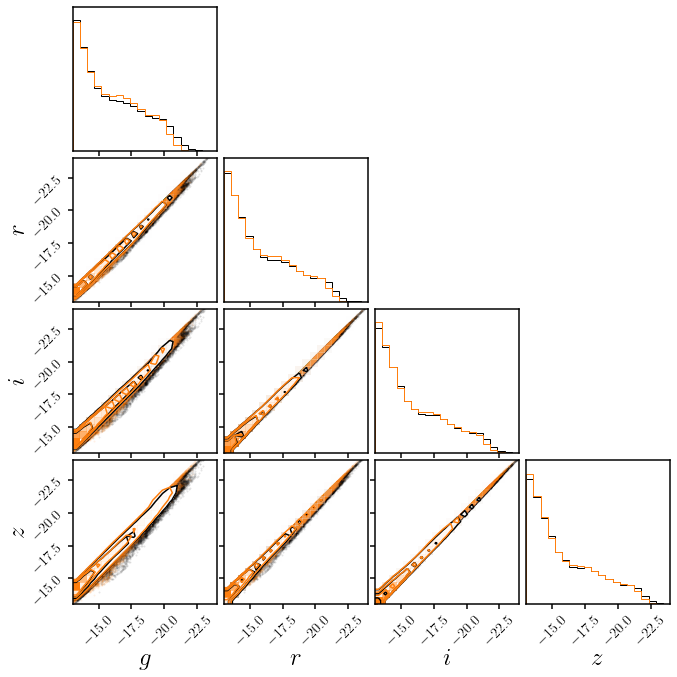

In [7]:
fig = DFM.corner(mags_unatten[::10], color='k', hist_kwargs={'density': True}, 
               range=[(-13, -24) for i in range(4)], labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']],
               label_kwargs={'fontsize': 25})
_ = DFM.corner(mags_atten[::10], color='C1', hist_kwargs={'density': True}, 
               range=[(-13, -24) for i in range(4)], labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']],
               label_kwargs={'fontsize': 25}, fig=fig)

(-0.25, 1.5)

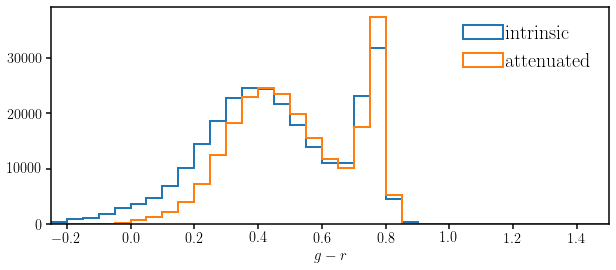

In [9]:
plt.figure(figsize=(10,4))
mag_lim = (mags_unatten[:,1] < -18)
plt.hist(mags_unatten[mag_lim][:,0] - mags_unatten[mag_lim][:,1], range=(-0.5, 1.5), bins=40, 
         histtype='step', linewidth=2, label='intrinsic')
mag_lim = (mags_atten[:,1] < -18)
plt.hist(mags_atten[mag_lim][:,0] - mags_atten[mag_lim][:,1], range=(-0.5, 1.5), bins=40, 
         histtype='step', linewidth=2, label='attenuated')
plt.legend(loc='upper right', fontsize=20, handletextpad=0.1)
plt.xlabel('$g-r$', fontsize=15)
plt.xlim(-0.25, 1.5)

(-0.25, 1.2)

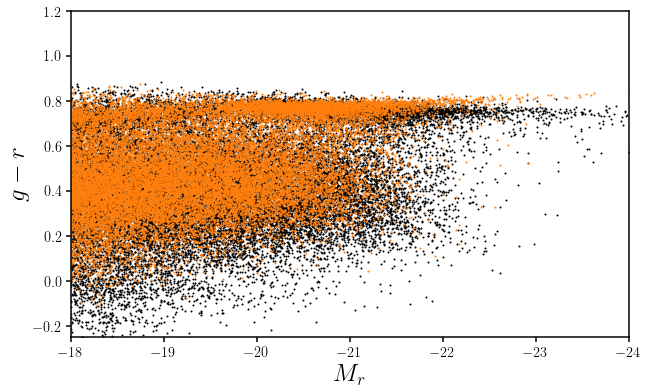

In [11]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(mags_unatten[::10,1], mags_unatten[::10,0] - mags_unatten[::10,1], c='k', s=1)
sub.scatter(mags_atten[::10,1], mags_atten[::10,0] - mags_atten[::10,1], c='C1', s=1)
sub.set_xlabel('$M_r$', fontsize=25)
sub.set_xlim(-18, -24)
sub.set_ylabel('$g-r$', fontsize=25)
sub.set_ylim(-0.25, 1.2)

# apply dust attenuation to CAMELS

find nearest neighbor in magnitude space then randomly select one of the angles

In [12]:
camels = h5py.File('/tigress/chhahn/goleta/tng.snap33.subfind.galaxies.LHC.hdf5', 'r')
mags_camels_unatten = camels['props'][-6:-2].T

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(mags_unatten)

NearestNeighbors(n_neighbors=1)

In [24]:
d_match, i_match = knn.kneighbors(mags_camels_unatten)

In [31]:
dmags = f['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:,1:5,:][mlim] - mags_unatten[:,:,None]

In [43]:
i_angles = np.random.choice(np.arange(12), size=720548)

mags_camels_atten = mags_camels_unatten.copy()
for i in range(12): 
    is_angle = (i_angles == i)
    mags_camels_atten[is_angle] = mags_camels_unatten[is_angle] + dmags[i_match[:,0]][is_angle][:,:,i]

In [46]:
np.savetxt('/tigress/chhahn/goleta/tng.snap33.subfind.galaxies.LHC.sdss_griz.tng_dust_emu.dat', mags_camels_atten, 
          header='g, r, i, z absolute magnitude')